### PDF query with langchain and CassandraDB (AstraDB)
- Will create cassandradb in a platform named "DataStax" (https://www.datastax.com/products/vector-search) which will create cassandradb in cloud itself and will able to perform vector search
- Vector Search enhances machine learning models by allowing similarity comparisons of embeddings, which are mathematical representations of high dimensional data

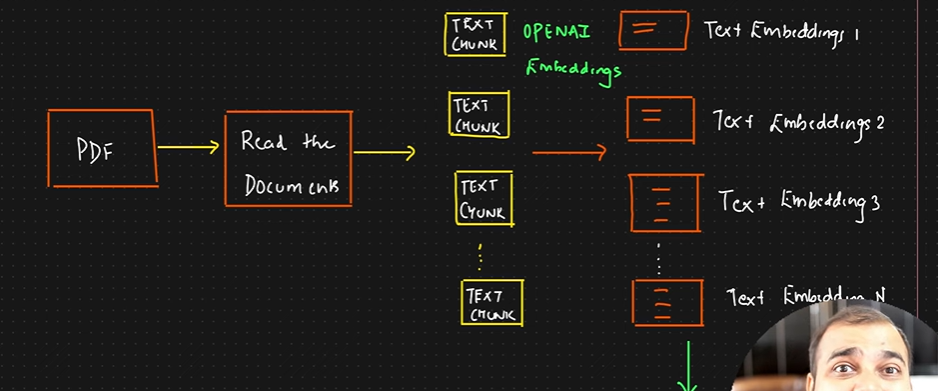
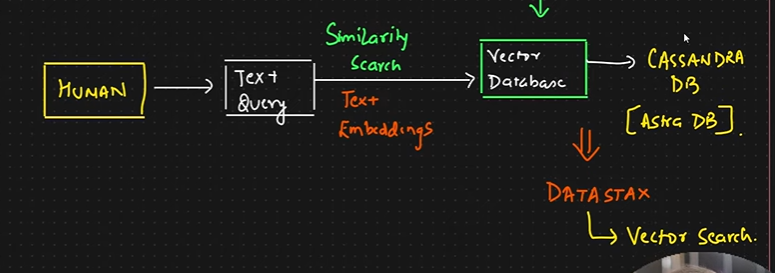

https://cassandra.apache.org/_/index.html
- Apache Cassandra is an open source NoSQL Database for managing massive amounts of data in faster way without losing sleep
- since these LLMs are stateless, they reply on a vector database like AstraDB to store the embeddings

You need a **Serverless CassandraDB with vector search** on AstraDB to run - https://astra.datastax.com 

Steps to create a Database:
1. Login in astradb
2. click on create a database and choose serverless vector which is astradb
3. fill the details and click on create
4. important information we required are:
    - database Id and token

!pip install -q cassio datasets langchain openai tiktoken PyPDF2

In [ ]:
from langchain.vectorstores.cassandra import Cassandra
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.llms import OpenAI
from langchain.embeddings import OpenAIEmbeddings
from PyPDF2 import PdfReader

# support for dataset retrieval with huggingface
from datasets import load_dataset

# with Cassio, the engine powering the Astradb integration in langchain, also initialize the db connection
import cassio

import os
from dotenv import load_dotenv

load_dotenv()

For setup, will be required these information of astra db connection details and openai keys, keep these in .env file or here:
- ASTRA_DB_APPLICATION_TOKEN (token starts with AstraCS:)
- ASTRA_DB_ID (database id)

In [ ]:
# read the pdf 
pdfreader=PdfReader('path-to-pdf.pdf')

from typing_extensions import Concatenate
raw_text=''
for i,page in enumerate(pdfreader.pages):
    content=page.extract_text()
    if content:
        raw_text+=content

In [ ]:
# initilaize the connection to database
cassio.init(token=os.getenv('ASTRA_DB_APPLICATION_TOKEN'),database_id=os.getenv('ASTRA_DB_ID'))

In [ ]:
# create llm and langchain embeddings
llm=OpenAI(openai_api_key=os.getenv("OPENAI_API_KEY"))
embeddings=OpenAIEmbeddings(openai_api_key=os.getenv("OPENAI_API_KEY"))

In [ ]:
# create langchain vectorstore using cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name='whatever table name you have given while creating',
    session=None,
    keyspac=None,
)

In [ ]:
# creating chunks of text content in pdf
from langchain.text_splitter import CharacterTextSplitter

text_splitter=CharacterTextSplitter(
    separator="\n",
    chunk_size=800,
    chunk_overlap=200,
    length_function=len,
)
texts=text_splitter.split_text(raw_text)

In [ ]:
# loading top 50 dataset into the vector store 
# (internally it will first apply the embedding to convert text to vector and then store it)
astra_vector+store.add_texts(texts[:50])
astra_vector_index=VectorStoreIndexWrapper(vectorstore=astra_vector_store)

In [ ]:
# quering the vector store
question='some question to ask'
answer=astra_vector_index.query(question,llm=llm).strip()
print(answer)

In [ ]:
for doc,score in astra_vector_store.similarity_search_with_score(question,k=4):
    print(score,doc.page_content[:84])